Loaded: (8000, 18)
[Outliers] Dropping 67 customers (3.41%)
Silhouette scores: {2: 0.313794300821335, 3: 0.30439132483408204, 4: 0.2897832776387029, 5: 0.2839199093558742, 6: 0.2680635856121251, 7: 0.28048888776388353, 8: 0.2727401781093198, 9: 0.27744353984649445, 10: 0.27989112693839807}
Best k by silhouette: 2

Cluster sizes:
cluster
0    606
1    682
2    612
Name: count, dtype: int64

Cluster Profile:
          recency_days  num_purchases  total_spent  churn
cluster                                                 
0              177.46           5.68    395483.91   0.26
1              276.39           3.14    133799.56   0.26
2               88.04           3.07    137807.68   0.23

Cluster Labels: {0: 'High-Value Loyal', 1: 'Dormant / At-Risk', 2: 'Emerging / Mid-Value'}


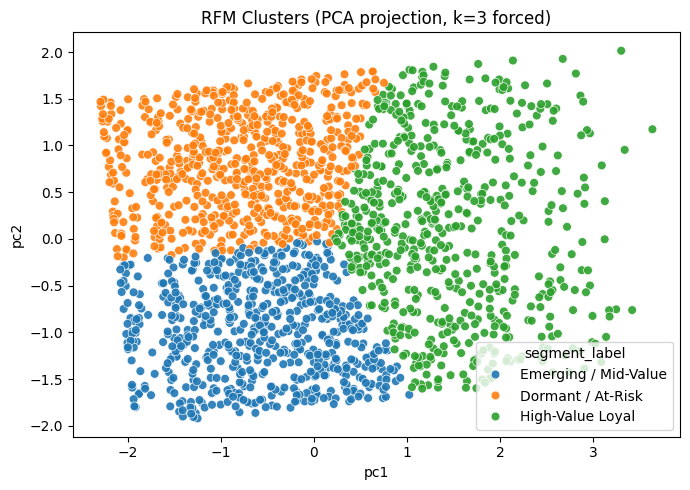

Explained variance by PC1+PC2: 0.849
Saved: ../data/processed/customers_with_clusters.csv
Saved: ../data/processed/cluster_profile.csv


In [5]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# -----------------------------
# Config
# -----------------------------
DATA_PATH = "../data/processed/cleaned_transactions.csv"
RANDOM_STATE = 42
IQR_K = 1.5           # outlier threshold
K_RANGE = range(2, 11)

# -----------------------------
# 1) Load + Aggregate customers
# -----------------------------
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)

cust = (
    df.groupby("customer_id").agg(
        age=("age","first"),
        tenure_months=("tenure_months","first"),
        last_purchase_date=("last_purchase_date","max"),
        total_spent=("total_value","sum"),
        num_purchases=("sale_id","count"),
        churn=("churn","first")
    )
    .reset_index()
)

cust["last_purchase_date"] = pd.to_datetime(cust["last_purchase_date"], errors="coerce")
max_date = pd.to_datetime(df["sale_date"]).max()
cust["recency_days"] = (max_date - cust["last_purchase_date"]).dt.days

# -----------------------------
# 2) Select RFM features
# -----------------------------
rfm_features = ["recency_days", "num_purchases", "total_spent"]
X = cust[rfm_features].copy().fillna(0)

# -----------------------------
# 3) Outlier removal (IQR)
# -----------------------------
def iqr_bounds(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    if iqr == 0 or np.isnan(iqr):
        return q1, q3
    return q1 - k*iqr, q3 + k*iqr

mask = pd.Series(True, index=X.index)
for col in rfm_features:
    lo, hi = iqr_bounds(X[col], IQR_K)
    mask &= X[col].between(lo, hi)

dropped = (~mask).sum()
print(f"[Outliers] Dropping {dropped} customers ({dropped/len(X)*100:.2f}%)")

cust = cust.loc[mask].reset_index(drop=True)
X = X.loc[mask].reset_index(drop=True)

# -----------------------------
# 4) Scale
# -----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 5) Silhouette analysis
# -----------------------------
sil_scores = {}
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

print("Silhouette scores:", sil_scores)
best_k = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette:", best_k)

# -----------------------------
# 6) Final clustering (force k=3)
# -----------------------------
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
cust["cluster"] = kmeans.fit_predict(X_scaled)

print("\nCluster sizes:")
print(cust["cluster"].value_counts().sort_index())

# -----------------------------
# 7) Cluster profiles
# -----------------------------
profile = cust.groupby("cluster")[rfm_features + ["churn"]].mean().round(2)
print("\nCluster Profile:\n", profile)

# -----------------------------
# 8) Auto-label clusters
# -----------------------------
labels = {}
med_rec = profile["recency_days"].median()
med_freq = profile["num_purchases"].median()
med_mon  = profile["total_spent"].median()

for cluster_id, row in profile.iterrows():
    rec, freq, mon = row["recency_days"], row["num_purchases"], row["total_spent"]

    if freq >= med_freq and mon >= med_mon and rec <= med_rec:
        labels[cluster_id] = "High-Value Loyal"
    elif rec > med_rec and (freq < med_freq or mon < med_mon):
        labels[cluster_id] = "Dormant / At-Risk"
    else:
        labels[cluster_id] = "Emerging / Mid-Value"

cust["segment_label"] = cust["cluster"].map(labels)
print("\nCluster Labels:", labels)

# -----------------------------
# 9) PCA visualization
# -----------------------------
pca = PCA(n_components=2, random_state=RANDOM_STATE)
coords = pca.fit_transform(X_scaled)
coords_df = pd.DataFrame(coords, columns=["pc1","pc2"])
coords_df["cluster"] = cust["cluster"].values
coords_df["segment_label"] = cust["segment_label"]

plt.figure(figsize=(7,5))
sns.scatterplot(data=coords_df, x="pc1", y="pc2", hue="segment_label", palette="tab10", s=40, alpha=0.9)
plt.title("RFM Clusters (PCA projection, k=3 forced)")
plt.tight_layout()
plt.show()

print("Explained variance by PC1+PC2:", round(pca.explained_variance_ratio_.sum(), 3))

# -----------------------------
# 10) Save outputs
# -----------------------------
cust_out_path = "../data/processed/customers_with_clusters.csv"
profile_out_path = "../data/processed/cluster_profile.csv"

cust.to_csv(cust_out_path, index=False)
profile.to_csv(profile_out_path)

print("Saved:", cust_out_path)
print("Saved:", profile_out_path)
